## Introduction to FAISS (Pinecone/James Briggs course)

In [1]:
import requests
import os

In [2]:
data_url = "https://raw.githubusercontent.com/jamescalam/data/main/sentence_embeddings_15K/"

In [ ]:
if not os.path.exists('../../data/data_faiss_intro'):
    os.mkdir('../../data/data_faiss_intro')

for i in range(57):
#     if i < 10:
#         i = '0' + str(i)
    res = requests.get(data_url+f"embeddings_{i}.npy")
    with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'wb') as fp:
        for chunk in res:
            fp.write(chunk)
    print('.', end='')

In [ ]:
res = requests.get(f"{data_url}sentences.txt")
with open(f"../../data/data_faiss_intro/sentences.txt", 'wb') as fp:
    for chunk in res:
        fp.write(chunk)

In [2]:
import numpy as np

In [3]:
for i  in range(57):
    if i == 0:
        with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'rb') as fp:
            sentence_embedding = np.load(fp)
    else:
        with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'rb') as fp:
            sentence_embedding = np.append(
                sentence_embedding, 
                np.load(fp), axis=0
            )      

In [4]:
sentence_embedding.shape

(14504, 768)

In [5]:
with open('../../data/data_faiss_intro/sentences.txt', 'r') as fp:
    lines = fp.read().split('\n')

In [6]:
lines[:5]

['A group of four children dancing in a backyard.',
 'The Conference Board said its measure of business confidence, which had fallen to 53 in the first quarter of 2003, improved to 60 in the most recent second quarter.',
 'a person eating a meal, often in a restaurant',
 'When you crossed the line, you violated the constitutional right," said Charles Weisselberg, who teaches law at the University of California, Berkeley.',
 "Ross Garber, Rowland's legal counsel, said the governor would have no comment on the condo deal."]

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [9]:
# model.encode(['Hello wolrd'], device='cuda', show_progress_bar=True)

In [10]:
import faiss

In [11]:
#IndexFlatL2 (eulidean distance)
d = sentence_embedding.shape[1]
index = faiss.IndexFlatL2(d)

In [12]:
index.is_trained

True

In [13]:
index.add(sentence_embedding)

In [14]:
index.ntotal

14504

In [15]:
xq = model.encode(['someone sprints with a football'], device = 'cuda')

In [16]:
k = 4 # similar vectors number

In [17]:
%%time
D, I = index.search(xq, k)
print(I)

[[ 4586 10252 12465   190]]
CPU times: user 76.8 ms, sys: 3.78 ms, total: 80.6 ms
Wall time: 72.9 ms


In [18]:
[f'{i}: {lines[i]}' for i in I[0]]

['4586: A group of football players is running in the field',
 '10252: A group of people playing football is running in the field',
 '12465: Two groups of people are playing football',
 '190: A person playing football is running past an official carrying a football']

## Speed improvement with syntethic data

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime


In [44]:
colors = ['#041BB3', '#E31957', '#12B0A7', '#000000']
sns.set_palette(sns.color_palette(colors))
sns.set_theme(font_scale=1.4)

In [45]:
def make_array(nb, d=100):
    return np.random.random((nb, d)).astype('float32')

In [78]:
def test(index, step=1_000, high=1_000_000, k=5, epochs=20):
    timer = np.zeros((epochs, int(high/step)))
    dim = np.zeros((int(high/step)))
    xq = make_array(1)
    for epoch in tqdm(range(epochs)):
        index.reset()
        iter_step = 0
        for i in range(step, high, step):
            wb = make_array(step)
            if not index.is_trained:
                index.train(wb)
            index.add(wb)
            # start timer
            start = datetime.now()
            D,I = index.search(xq, k)
            time_taken = (datetime.now() - start).microseconds
            timer[epoch, iter_step] = time_taken
            dim[iter_step] = i
            iter_step += 1
    timer = np.median(timer, axis=0)
    return dim, timer

In [79]:
d = 100
tests = pd.DataFrame({
    'num_vectors' : [],
    'query_time': [],
    'test': []
})


In [96]:
# Flat L2 Index
index = faiss.IndexFlatL2(d)

In [97]:
res = faiss.StandardGpuResources()  # use a single GPU
# make it into a gpu index
gpu_index = faiss.index_cpu_to_gpu(res, 0, index)

In [98]:
%%time
# test with GPU faiss time
dim, time = test(gpu_index,step=1_000, high=100_000, k=5, epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]

CPU times: user 17.1 s, sys: 1.33 s, total: 18.4 s
Wall time: 22.7 s


In [99]:
%%time
# test with CPU faiss 
dim, time = test(index,step=1_000, high=100_000, k=5, epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.31s/it]

CPU times: user 45.9 s, sys: 395 ms, total: 46.3 s
Wall time: 46.1 s


In [100]:
# continuation of the example with GPU (faster)
dim, time = test(gpu_index)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [13:26<00:00, 40.32s/it]


In [102]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'FlatL2'
tests = tests.append(df, ignore_index=True)

Text(0, 0.5, 'query time (ms)')

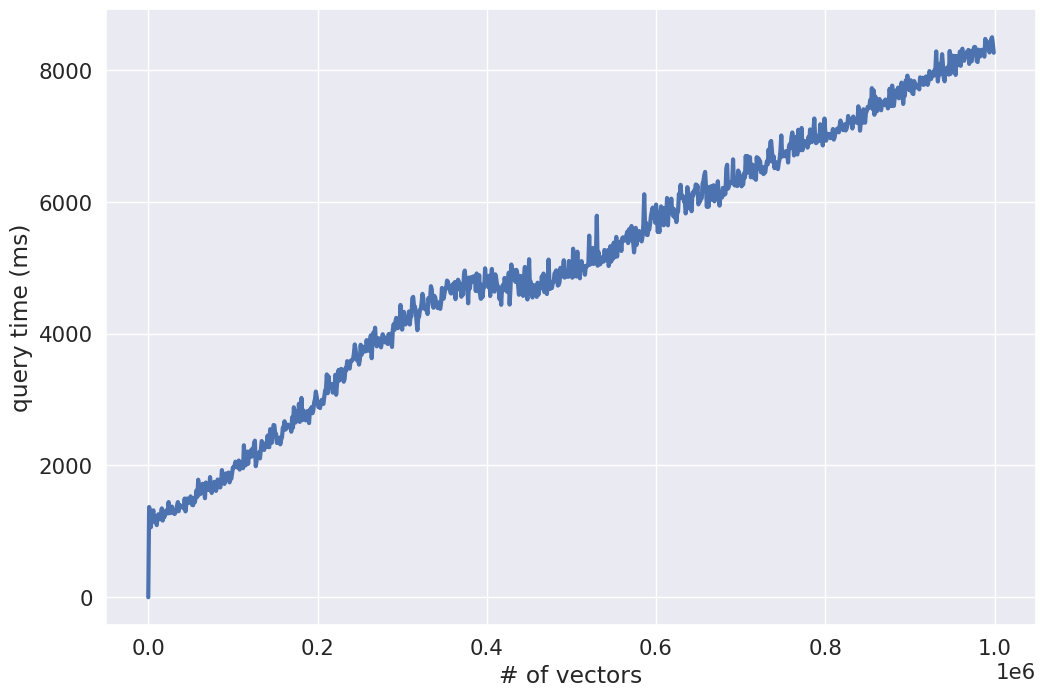

In [107]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(x='num_vectors', y='query_time', 
                  data=tests[tests.test == 'FlatL2'],
                  linewidth = 3)
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')